<a href="https://colab.research.google.com/github/ayeshagunarathne/Vision-Transformers/blob/main/Vision_transformer_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial is based on the paper title : AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE (https://arxiv.org/abs/2010.11929)


This is the architeuture used by the paper for the classification of images








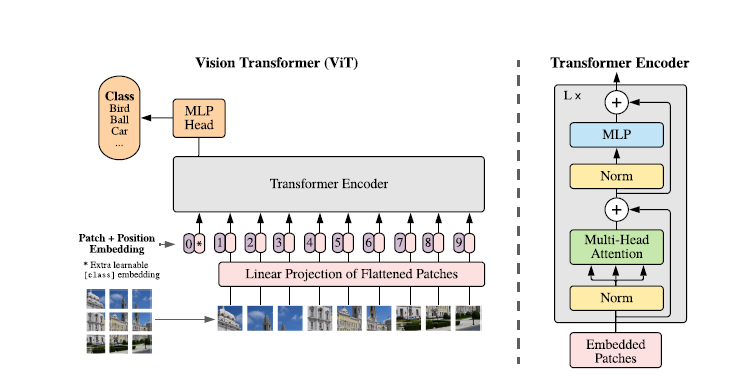


Given below is the explanation given in the paper for this architecture:

"We split an image into fixed-size patches, linearly embed each of them,
add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. In order to perform classification, we use the standard approach of adding an extra learnable “classification token” to the sequence. The illustration of the Transformer encoder was inspired by
Vaswani et al. (2017)."


## **Why split an image into patches?**

If we look at a normal image of resolution 256x256 (which is the resolution of imagenet dataset images.) If we try to apply the self attention to such an image,then each of the 256x256 pixels should attent to each other.So it would be computationally difficult to model such a system with billions of weights.

So best thing is to split the images into patches.
In the paper they split the image into 16x16 patches.

They basically perform global attention using image patches.

Shown below is how we can split a RGB image into patches of desired size.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


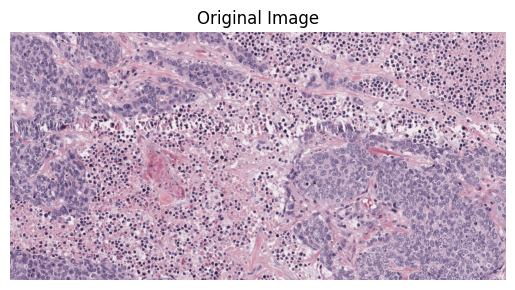

Number of patches: 8192


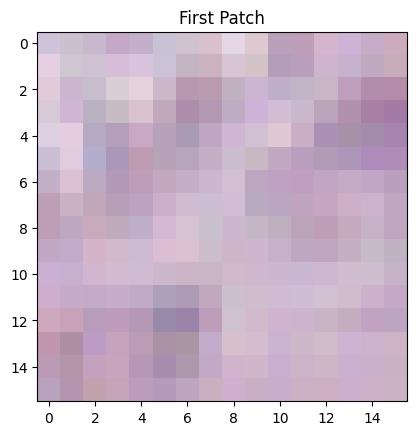

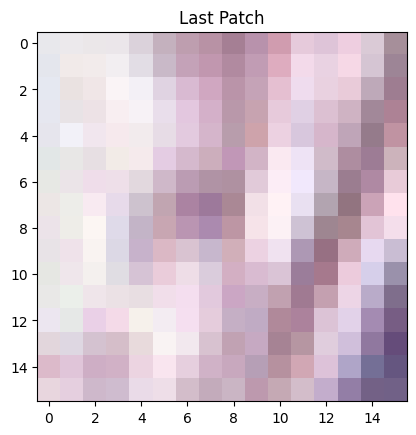

In [12]:
#Splitting an image into patches
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split_image_into_patches(image, patch_size):
    """
    Splits an image into non-overlapping patches of the given size.

    Args:
        image (np.ndarray): The input image as a NumPy array.
        patch_size (int): The size of the square patches.

    Returns:
        list of np.ndarray: List of image patches.
    """
    patches = []
    h, w, c = image.shape

    # Ensure image is divisible by patch size
    assert h % patch_size == 0, "Image height is not divisible by patch size."
    assert w % patch_size == 0, "Image width is not divisible by patch size."

    # Split the image into patches
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    return patches

# Load an example image
# Mounting Google drive folder to Colab
from google.colab import drive
drive.mount('/content/drive')
image = cv2.imread("/content/drive/My Drive/Colab Notebooks/1.tif",1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
plt.show()

# Define the patch size
patch_size = 16  # Example patch size

# Split the image into patches
patches = split_image_into_patches(image, patch_size)

# Example: print the number of patches
print(f'Number of patches: {len(patches)}')

# Display the first patch
plt.imshow(patches[0])
plt.title("First Patch")
plt.show()


# Display the last patch
plt.imshow(patches[-1])
plt.title("Last Patch")
plt.show()



## **Why a linear projection is applied to flattened patches?**

The reason is to transform image patches into a format that the transformer can process.

For example: In the paper the embeddings for each patch were set to various dimensions depending on the model size. For example, in their base model (ViT-B), the embedding dimension was 768.

So patches of size 16x16x3 needs to be flattened first and then converted into the respective embedding dimension of the transformer.This is done through a linear tranformation

Shown below is a sample python code which depicts the process taking place during linear projection.



In [13]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # Apply the linear projection (1x1 convolution)
        x = self.proj(x)  # Shape: (B, embed_dim, num_patches_h, num_patches_w)
        # Flatten the spatial dimensions
        x = x.flatten(2)  # Shape: (B, embed_dim, num_patches_h * num_patches_w)
        # Transpose to get the final shape
        x = x.transpose(1, 2)  # Shape: (B, num_patches_h * num_patches_w, embed_dim)
        return x

# Example usage
img = torch.randn(1, 3, 224, 224)  # Example image tensor (batch_size, channels, height, width)
patch_size = 16
embed_dim = 768

model = PatchEmbedding(in_channels=3, patch_size=patch_size, embed_dim=embed_dim)
patches = model(img)  # Transform image into patch embeddings

print(patches.shape)  # Output shape: (1, num_patches, embed_dim)


torch.Size([1, 196, 768])


## **What is a positional embedding and why it is used in ViT?**

The patches fed into the transformer parallely,so there's no connection between them, So transformer doesn't know the spatial relationship between these patches.So a positional embedding is to understand the order or spatial arrangement of tokens or patches.

Here learnable position embedings are used.Also the positional embeddings have the same dimensionality as the patch embeddings, which is usually the model’s embedding dimension.

It's shape can be described as follows :If there are N patches and the embedding dimension is D. the positional embeddings will be of shape
[1,N,D]

The learned positional embeddings are added to the patch embeddings before being fed into the transformer layers. This addition incorporates positional information into the embeddings of each patch.

Training: These embeddings are initialized randomly and learned during the training process. The model adjusts them to capture the spatial relationships between patches effectively.




## **What is a CLS embedding (class embedding)?**

This is a learnable embedding which is used to put together all the information from the patches and then to produce a final representation for the classification process.

Usually this is intialized randomly and updated during training.

This CLS token is concatenated to the beginning of the sequence of patch embeddings. For example, if there are Npatches and the embedding dimension is
D ,the sequence fed into the transformer will have shape [1,N+1,D]


